In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler

print("Libraries imported successfully!")


Libraries imported successfully!


In [4]:
import os
print(os.listdir("/Users/kdn_aigayatrikadam/Desktop/Projects/Project-5/AI Powered financial reporting/backend/data_processing/financial_reports"))


['AAPL_cash_flow.csv', '.DS_Store', 'cleaned', 'IBM_income_statement.csv', 'AAPL_income_statement.csv', 'IBM_cash_flow.csv', 'AAPL_balance_sheet.csv', 'IBM_balance_sheet.csv']


In [5]:
# Load cleaned financial data (e.g., Balance Sheet)
df = pd.read_csv("/Users/kdn_aigayatrikadam/Desktop/Projects/Project-5/AI Powered financial reporting/backend/data_processing/financial_reports/cleaned/AAPL_balance_sheet_cleaned.csv")


# Convert "Year" column to datetime and sort
df["year"] = pd.to_datetime(df["year"])
df = df.sort_values("year")

# Select relevant financial metric for forecasting
target_col = "totalassets"  # Example: Predict total assets
data = df[[target_col]].values  # Convert to NumPy array

print("Data loaded and sorted successfully!")


Data loaded and sorted successfully!


In [6]:
# Convert "Year" column to datetime and sort
df["year"] = pd.to_datetime(df["year"])
df = df.sort_values("year")

print("Data sorted by year:")
print(df.head())  # Display first few rows


Data sorted by year:
         year  reportedcurrency   totalassets  totalcurrentassets  \
16 2008-09-30               0.0   36171000000         30006000000   
15 2009-09-30               0.0   47501000000         31555000000   
14 2010-09-30               0.0   75183000000         41678000000   
13 2011-09-30               0.0  116371000000         44988000000   
12 2012-09-30               0.0  176064000000         57653000000   

    cashandcashequivalentsatcarryingvalue  cashandshortterminvestments  \
16                            11875000000                  11875000000   
15                             5263000000                  23464000000   
14                            11261000000                  25620000000   
13                             9815000000                  25952000000   
12                            10746000000                  29129000000   

     inventory  currentnetreceivables  totalnoncurrentassets  \
16   509000000           0.000000e+00             48820

In [7]:
# Select relevant financial metric for forecasting
target_col = "totalassets"  # Example: Predict total assets

# Convert the selected column to a NumPy array
data = df[[target_col]].values  

print("Selected target column data (first 5 rows):")
print(data[:5])  # Print first 5 rows


Selected target column data (first 5 rows):
[[ 36171000000]
 [ 47501000000]
 [ 75183000000]
 [116371000000]
 [176064000000]]


In [8]:
from sklearn.preprocessing import MinMaxScaler

# Normalize data using MinMaxScaler (scales values between 0 and 1)
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

print("First 5 rows of normalized data:")
print(data_scaled[:5])  # Print first 5 rows after scaling



First 5 rows of normalized data:
[[0.        ]
 [0.03340724]
 [0.11502943]
 [0.23647493]
 [0.41248364]]


In [9]:
# Function to convert data into sequences for LSTM
def create_sequences(data, seq_length):
    sequences, targets = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])  # Input sequence
        targets.append(data[i+seq_length])      # Corresponding target value
    return np.array(sequences), np.array(targets)

# Set sequence length (look-back window)
seq_length = 5  # Using past 5 years to predict next year

# Generate sequences
X, y = create_sequences(data_scaled, seq_length)

print(f"Sequences created! X shape: {X.shape}, y shape: {y.shape}")


Sequences created! X shape: (12, 5, 1), y shape: (12, 1)


In [10]:
import torch

# Convert NumPy arrays to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

print("Data successfully converted to PyTorch tensors!")
print(f"X_tensor shape: {X_tensor.shape}, y_tensor shape: {y_tensor.shape}")


Data successfully converted to PyTorch tensors!
X_tensor shape: torch.Size([12, 5, 1]), y_tensor shape: torch.Size([12, 1])


In [11]:
import torch.nn as nn

# Define LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)  # LSTM layer
        return self.fc(lstm_out[:, -1, :])  # Fully connected layer (output last timestep)

print("LSTM Model class defined successfully!")


LSTM Model class defined successfully!


In [12]:
import torch.optim as optim

# Model setup
input_dim = 1  # One financial metric
hidden_dim = 64  # Number of LSTM neurons per layer
output_dim = 1  # Predicting a single value
num_layers = 2  # Number of stacked LSTM layers

# Instantiate the model
model = LSTMModel(input_dim, hidden_dim, output_dim, num_layers)

# Define Mean Squared Error (MSE) Loss Function
criterion = nn.MSELoss()

# Use Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Model, loss function, and optimizer initialized successfully!")


Model, loss function, and optimizer initialized successfully!


In [13]:
# Training loop
epochs = 100  # Number of training iterations
for epoch in range(epochs):
    model.train()  # Set model to training mode
    optimizer.zero_grad()  # Clear previous gradients

    # Forward pass
    output = model(X_tensor)
    loss = criterion(output, y_tensor)  # Compute loss

    # Backward pass
    loss.backward()  # Compute gradients
    optimizer.step()  # Update weights

    # Print loss every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

print("Training complete!")


Epoch 0, Loss: 0.649507462978363
Epoch 10, Loss: 0.2727011740207672
Epoch 20, Loss: 0.047684311866760254
Epoch 30, Loss: 0.015269222669303417
Epoch 40, Loss: 0.01799088530242443
Epoch 50, Loss: 0.01501514296978712
Epoch 60, Loss: 0.011425647884607315
Epoch 70, Loss: 0.009715846739709377
Epoch 80, Loss: 0.008707033470273018
Epoch 90, Loss: 0.007935632020235062
Training complete!


In [14]:
# Set model to evaluation mode
model.eval()

# Make predictions
with torch.no_grad():
    predictions = model(X_tensor).numpy()  # Convert to NumPy array

print("Predictions made successfully!")
print(predictions[:5])  # Display first 5 predicted values


Predictions made successfully!
[[0.6436561 ]
 [0.68125415]
 [0.7248024 ]
 [0.7731341 ]
 [0.82093334]]


In [15]:
# Inverse transform the predictions back to the original financial scale
predicted_values = scaler.inverse_transform(predictions)

print("Predicted future total assets (original scale):")
print(predicted_values[:5])  # Display first 5 predictions


Predicted future total assets (original scale):
[[2.5446567e+11]
 [2.6721698e+11]
 [2.8198627e+11]
 [2.9837790e+11]
 [3.1458889e+11]]


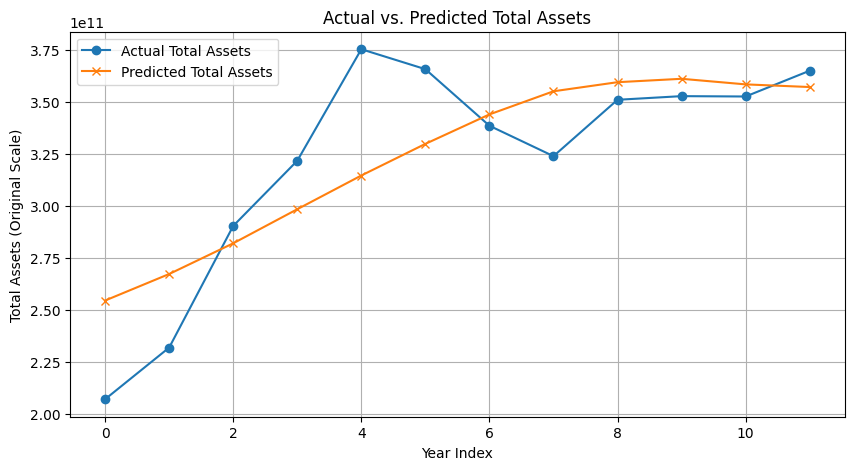

In [17]:
import matplotlib.pyplot as plt

# Prepare actual vs. predicted values
actual_values = scaler.inverse_transform(y_tensor.numpy())  # Convert y_tensor back to original scale

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(actual_values, label="Actual Total Assets", marker='o')
plt.plot(predicted_values, label="Predicted Total Assets", marker='x')
plt.xlabel("Year Index")
plt.ylabel("Total Assets (Original Scale)")
plt.title("Actual vs. Predicted Total Assets")
plt.legend()
plt.grid()
plt.show()


In [18]:
print(df.head())  # Check first few rows
print(df.tail())  # Check last few rows
print(f"Dataset contains {len(df)} years of data.")


         year  reportedcurrency   totalassets  totalcurrentassets  \
16 2008-09-30               0.0   36171000000         30006000000   
15 2009-09-30               0.0   47501000000         31555000000   
14 2010-09-30               0.0   75183000000         41678000000   
13 2011-09-30               0.0  116371000000         44988000000   
12 2012-09-30               0.0  176064000000         57653000000   

    cashandcashequivalentsatcarryingvalue  cashandshortterminvestments  \
16                            11875000000                  11875000000   
15                             5263000000                  23464000000   
14                            11261000000                  25620000000   
13                             9815000000                  25952000000   
12                            10746000000                  29129000000   

     inventory  currentnetreceivables  totalnoncurrentassets  \
16   509000000           0.000000e+00             4882000000   
15   4550000